# Billlboard Hot 100 Charts: How to Make the Cut
***
<img style="float: left; width: 200px; padding: 3mm;" src="https://static.billboard.com/files/media/billboard-logo-b-20-billboard-1548-compressed.jpg" alt="Drawing"/>  

Billboard Hot 100 is a record chart published weekly by *Billboard* magazine that stands as the industry standard for the United States. Its methods of ranking have fluctuated over the years from jukebox plays to YouTube views. Recently, there have been three metrics that are factored into what songs make it on the chart: airplay, streaming, and album sales (**source: https://blog.sonicbids.com/3-ways-to-get-on-the-billboard-charts**). Airplay is tracked through Broadcast Data Systems that uses digital technology to identify songs that play on radio and TV channels.Streaming and social interactions on popular platforms like Spotify and YouTube have been a recent factor. Finally, Nielsen SoundScan is utilized to track sales of music through scanned bar codes. 

There are other record charts that use different measuring tools and while this chart hasn’t been proven to accurately determine the actual popularity of a song, it remains a strong influencer for the sale success of prominent artists. Therefore, my focus here will stick with the Billboard Hot 100 despite its pitfalls. More specifically, I will look at songs that have been on the top 100 from 1999 – 2019. Additionally, I will look at data extracted from Spotify that looks at song qualities to see if I can draw any predictions on:


 - Popular genre trends
 - Likelihood of an artist to appear on the chart multiple times
 - Song qualities that contribute to getting on the chart

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

First, I'll read in the data (**source: https://www.kaggle.com/danield2255/data-on-songs-from-billboard-19992019**) and clean up unnecessary info:

In [4]:
file_path = 'billboardHot100_1999-2019.csv'
df = pd.read_csv(file_path)

#clean up unnecessary data
df = df.drop(['Week','Writing.Credits','Lyrics'],1) 
df.head(10)

,Unnamed: 0,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Date,Genre,Features
0,1,"Lil Nas,",Old Town Road,1,1.0,7.0,"April 5, 2019","Country,Atlanta,Alternative Country,Hip-Hop,Tr...",Billy Ray Cyrus
1,2,"Shawn Mendes, Camila Cabello",Senorita,2,NaN,NaN,"June 21, 2019",Pop,NaN
2,3,Billie Eilish,Bad Guy,3,2.0,13.0,"March 29, 2019","Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ...",NaN
3,4,Khalid,Talk,4,3.0,20.0,"February 7, 2019","Synth-Pop,Pop",NaN
4,5,"Ed Sheeran, Justin Bieber",I Don't Care,5,2.0,7.0,"May 10, 2019","Canada,UK,Dance,Dance-Pop,Pop",NaN
5,6,Jonas Brothers,Sucker,6,1.0,17.0,"March 1, 2019","Alternative Pop,Boy Band,Teen Pop,Pop-Rock,Pop",NaN
6,7,DaBaby,Suge,7,7.0,13.0,"March 1, 2019","Trap,East Coast,Rap",NaN
7,8,Drake,Money In The Grave,8,7.0,2.0,"June 15, 2019","Hip-Hop,Rap,Basketball,NBA,Canada",Rick Ross
8,9,Chris Brown,No Guidance,9,9.0,3.0,"June 8, 2019","Alternative R&;B,Hip-Hop,Rap,Pop,DMV,Canada,R&;B",Drake
9,10,Post Malone,Wow.,10,2.0,27.0,"December 24, 2018","Memes,Hip-Hop,Trap,Rap",NaN


Now, let's first take a look at what genres are represented. Since a song can have multiple genre categories, I will extract each of the genres separately and utilize python to look at all of the genres represented in our data:

In [5]:
#split each string in the genre category using comma as delimiter
df['Genre'] = df['Genre'].apply(lambda s: s.split(',')) 

#make a new dataframe for 'Genre'
dfClumpedGenres = df['Genre']

#generate a list of genres
genre_list = [item for sublist in dfClumpedGenres for item in sublist]
#set(genre_list)

Now let's break down each genre by how many times it's represented:

In [10]:
#sort genre list by number of occurences in descending order, get rid of duplicates
gen_list_sorted = sorted(set(genre_list), key = lambda ele: genre_list.count(ele),reverse = True)

#dictionary containing genre title and number of times it appears on Billboard Hot 100
genre_dict = {gen_list_sorted[gen]: genre_list.count(gen_list_sorted[gen]) for gen in range(len(gen_list_sorted))} 

#print everything in genre_dict
#for genre in genre_dict: print(genre, genre_dict[genre])

print(f'Number of genres: {len(genre_dict)}')

Number of genres: 334


That's a lot of genres! We need to make this more manageable in order to gain any useful info. Instead let's look at the top 20 genres represented and plot it as a bar graph:

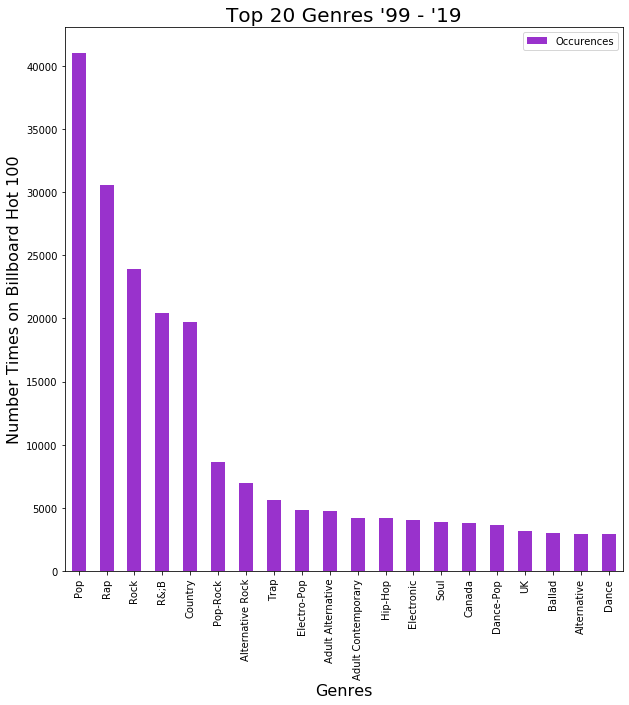

In [5]:
from pandas import DataFrame

#convert dictionary to data frame
genre_count = DataFrame(list(genre_dict.items()),columns = ['Genre','Occurences']) 

#Look at top 20 genres. Since data is organized in descending order, we'll select first 20 rows
fig, ax = plt.subplots(figsize=(10,10))
genre_count.iloc[0:20].plot(kind='bar', x = 'Genre',ax=ax,facecolor='darkorchid')
ax.set_title("Top 20 Genres '99 - '19", fontsize=20) 
ax.set_xlabel("Genres", fontsize=16)
ax.set_ylabel("Number Times on Billboard Hot 100", fontsize=16)
plt.show()

The above chart inidcates that the top 5 genres are Pop, Rap, Rock, R&B, and Country. This doesn't include some of the offshoots of these main genres such as Alternative Rock, Electro-Pop, and Hip-Hop, all of which are subgenres of Rock, Pop, and Rap, respectively and are also included in the top 20. This suggests that the top 5 genres dominate even more so than is displayed. However, how are these genres concentrated in the top of the top? Intuitively, it would seem that each of the top 5 would dominate the peak positions in accordance to how they're represented as shown. Let's use probability to confirm this intuition. To do this, I'll be looking at the probability that a song would be peaked in the top 10 positions given that it's a pop song.

Let $A$ be the event that a song peaks in the top 10 and $B$ be the event that the song is classified solely as Pop,

In order to find the probability that a song peaks in the top 10 given that it's a pop song we need to find $P(A \mid B) = \dfrac{P(A \cap B)}{P(B)}$

This is caluclated below:

In [6]:
#calculate chance hot 100 is a pop song
prob_pop_song = genre_dict['Pop']/(sum(genre_dict.values()))
print(f"Probability Hot 100 song is classifed as Pop genre: {prob_pop_song}")

# #calculate chance hot 100 song peaked within top 10 AND is a pop song
nrows = df.shape[0]
check_top_10_and_pop = df.apply(lambda x: True if (x['Peak.position'] <= 10) and ('Pop' in x['Genre']) else False , axis=1)
num_both_conditions = len(df[check_top_10_and_pop == True].index)
prob_both_conditions = num_both_conditions/nrows
print(f"Probability Hot 100 song peaks in top 10 AND is a pop song:{prob_both_conditions} ")

#find probability top 10 given pop song
prob_top10_given_pop = prob_both_conditions/prob_pop_song
print(f'Probability that song peaks in the top 10 given that it is a pop song: {prob_top10_given_pop}')

Probability Hot 100 song is classifed as Pop genre: 0.14781377043508348
Probability Hot 100 song peaks in top 10 AND is a pop song:0.1471946515813834 
Probability that song peaks in the top 10 given that it is a pop song: 0.9958114940720494


The results goes against my intuition. While Pop songs represent 14% of all Billboard Hot 100 songs, they account for nearly 99.6% of all songs that peak within the top 10. This doesn't include the subgenres of pop which would put this value even higher. This suggests that pop is indeed a much more popular genre, at least when it comes to sales. However, it should also be taken into account the fact that many songs can, once again, be in multiple genre categories. So instead of claiming pop songs as the having the highest popularity, perhaps it's best to see songs that have pop-style song qualities as being more popular. I will look more into this when analyzing song features later on.

Before I do that, below is a distribution of genres across the Billboard chart. I've combined sub-genres together with the top 5 most popular genres in order to visualize the degree of diversity on the chart.

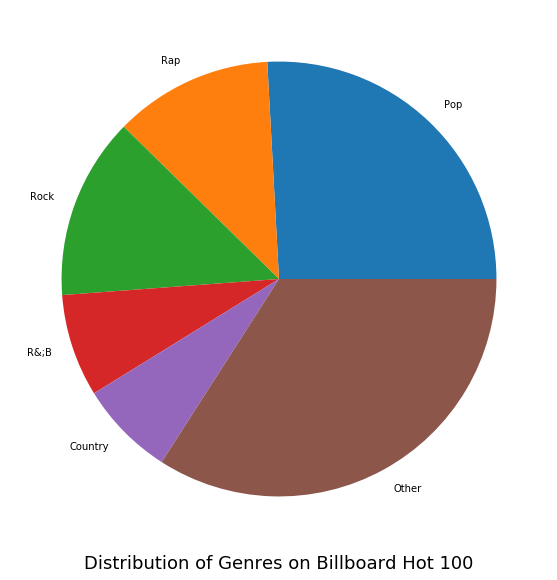

In [7]:
#create new dict for pie chart
combine_subs = {
    'Pop': genre_dict['Pop'],
    'Rap': genre_dict['Rap'],
    'Rock': genre_dict['Rock'],
    'R&;B': genre_dict['R&;B'],
    'Country': genre_dict['Country']
}

#combine sub-genres in top 5 categories
#print('Pop', genre_dict['Pop'])
for gen in genre_dict:
        if "Pop" in gen and gen != 'Pop': 
            #print(gen,genre_dict[gen])
            combine_subs['Pop']+= genre_dict[gen]
        elif "Rap" in gen and gen != 'Rap': combine_subs['Rap']+= genre_dict[gen]
        elif "Rock" in gen and gen != 'Rock': combine_subs['Rock']+= genre_dict[gen]
        elif "Country" in gen and gen != 'Country': combine_subs['Country']+= genre_dict[gen]
        elif "R&;B" in gen and gen != 'R&;B': combine_subs['R&;B']+= genre_dict[gen]

#subtract number of top 5 from total to get all other genres
top_5_total = sum(combine_subs.values())
combine_subs['Other'] = len(genre_list) - top_5_total

fig= plt.figure(figsize=(10,10))
plt.pie([float(v) for v in combine_subs.values()], labels=[k for k in combine_subs],
            autopct=None)
plt.xlabel('Distribution of Genres on Billboard Hot 100', fontsize=18)
plt.show()

Now that we've gotten a grasp on what genres are most represented, let's see the trend in reoccuring artists. What kind of distribution do new artists have on these charts? I'll do this by seeing the likelihood that an artist who has been on billboard will appear once again. First, let's run the numbers:

In [8]:
#dataframe that shows Artists and corresponding times their hits have been on Billboard
artistCounts_series = df['Artists'].value_counts()
dfArtistCounts = artistCounts_series.to_frame()
dfArtistCounts.reset_index(inplace=True)
dfArtistCounts.columns = ['Artist','Billboard Hits 1999 - 2019']
dfArtistCounts.head(10)

,Artist,Billboard Hits 1999 - 2019
0,Drake,1089
1,Taylor Swift,954
2,Rihanna,823
3,Kenny Chesney,700
4,Maroon 5,677
5,Keith Urban,665
6,Beyonce,651
7,Chris Brown,637
8,Tim McGraw,627
9,Rascal Flatts,624


Above are the 10 artists with the most number of Billboard hits within the past 20 years. Let's find out probability of recurring artists in our sample set:

In [9]:
def compute_prob(i):
    i_or_more = dfArtistCounts.loc[dfArtistCounts['Billboard Hits 1999 - 2019'] >= i]
    return len(i_or_more)/len(dfArtistCounts)

#probability of having 2 or more hits
print(f'Probability that an artist will be on the Hot 100 more than once: {compute_prob(2)}')

#probability of having more than 3 or more hits
print(f'Probability that an artist will be on the Hot 100 three or more times: {compute_prob(3)}')

Probability that an artist will be on the Hot 100 more than once: 0.9110884006131834
Probability that an artist will be on the Hot 100 three or more times: 0.8681655595298927


This means that only $\approx$9% of the artists that appear on Billboard Hot 100 will be artists that weren't featured before. Let's take a look at the probability distribution of appearing on Billboard after having multiple songs that have made the cut:

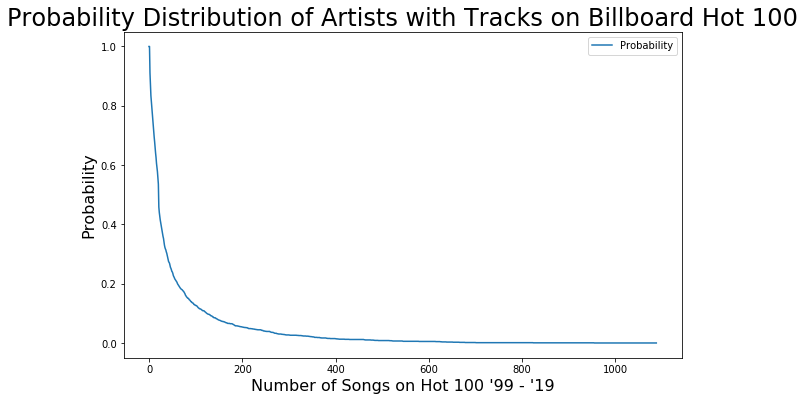

In [10]:
most_hits = max(dfArtistCounts['Billboard Hits 1999 - 2019'])
index = [i for i in range(most_hits)]

prob_dist_data = {'Probability':[compute_prob(i) for i in range(most_hits)]}

df_prob_dist = pd.DataFrame(prob_dist_data, index)

fig, ax = plt.subplots(figsize=(10,6))
df_prob_dist.plot(ax = ax)
ax.set_xlabel("Number of Songs on Hot 100 '99 - '19", fontsize=16)
ax.set_ylabel("Probability", fontsize=16)
ax.set_title("Probability Distribution of Artists with Tracks on Billboard Hot 100", fontsize=24)
plt.show()

While, the intution of getting multiple songs on Billboard being very difficult makes sense, the takeaway here is that, of the artists featured, they more than likely have more than one song that's also popular. Not only are the charts concentrated on very few genres, they are also indeed very concentrated on a few artists. Missing in our data are the album titles for the multiple songs that each artist released. Therefore, it can't be said for sure that songs released as collection will be more likely to make on it the charts as a collection.

This further implies that popular songs don't offer a wide range of variety as a combination of both style and artists. Does this mean that Billboard is totally disconnected from the actual tastes of the general populace? In other words, is mainstream music concentrated on massive sales of a small portion of the population or do they match with tastes of people? To look into this we need to first extract data on peoples' musical preferences:

In [11]:
file_path = 'music_genre_tastes.csv'
dfGenreTaste = pd.read_csv(file_path)
dfGenreTaste = dfGenreTaste.drop("Unnamed: 2", axis=1)
dfGenreTaste = dfGenreTaste.dropna()
dfGenreTaste = dfGenreTaste.reset_index(drop=True)
dfGenreTaste.rename(columns = {'Unnamed: 1':'Percentile'}, inplace = True)
dfGenreTaste

,Music genres preferred by consumers in the U.S. 2018,Percentile
0,Rock,56.8
1,Pop,56.1
2,Country,49.9
3,R&B and Soul,38.9
4,Hip Hop,37.4
5,Easy Listening,32.7
6,Electronic/dance,20.6
7,Jazz,20.2
8,Blues,20.0
9,Classical and Opera,17.4


Above is an overview of the music genre tastes in the U.S. in 2018 (**source:https://www.statista.com/statistics/442354/music-genres-preferred-consumers-usa/)** Let's put this into a bar plot to visualize the differences between this and Billboard.

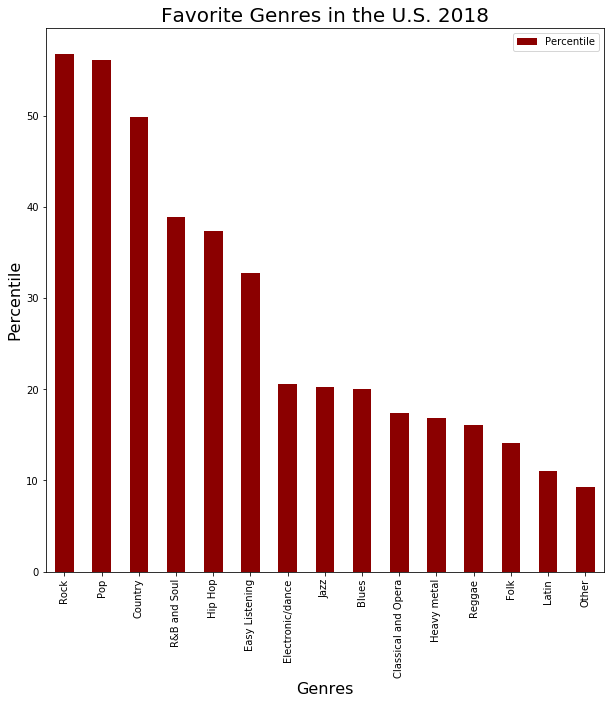

In [12]:
#Plot musical preferences data
fig, ax = plt.subplots(figsize=(10,10))
dfGenreTaste.plot(kind='bar', x = 'Music genres preferred by consumers in the U.S. 2018',ax=ax,facecolor='darkred')
ax.set_title("Favorite Genres in the U.S. 2018", fontsize=20) 
ax.set_xlabel("Genres", fontsize=16)
ax.set_ylabel("Percentile", fontsize=16)
plt.show()

This paints a different picture for the listening habits of Americans. While the top 5 genres remain the same (we'll consider Hip-Hop and Rap as the same genre as well as R&B and Soul), The ordering of the top 5 differs from what is displayed through Billboard. So while Billboard may display what's currently trending, it doesn't take into account the actual musical tastes of the general population. This could be based off of a lot of factors including: age demographics, how people purchase their music, and live events.  This opens a wider door for those styles under-represented if they attempt to reach their audience through means other than streaming or airplay. Nonetheless, Pop remains a powerhouse for a chunk of the music industry. For my final analysis, I'll look at Spotify sound quality metrics that looks at songs in the previous decade to see if I can correlate sound qualities and positioning on the billboard:

In [13]:
file_path = 'top_10s_.csv'
dfSounds = pd.read_csv(file_path)
dfSounds = dfSounds.dropna()
dfSounds.head(10)

,Column1,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
1,2,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82
2,3,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80
3,4,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79
4,5,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78
5,6,Baby,Justin Bieber,canadian pop,2010,65,86,73,-5,11,54,214,4,14,77
6,7,Dynamite,Taio Cruz,dance pop,2010,120,78,75,-4,4,82,203,0,9,77
7,8,Secrets,OneRepublic,dance pop,2010,148,76,52,-6,12,38,225,7,4,77
8,9,Empire State of Mind (Part II) Broken Down,Alicia Keys,hip pop,2010,93,37,48,-8,12,14,216,74,3,76
9,10,Only Girl (In The World),Rihanna,barbadian pop,2010,126,72,79,-4,7,61,235,13,4,73


Above is data has the top songs by year in the world by Spotify that is based on Billboard (**source: https://www.kaggle.com/leonardopena/top-spotify-songs-from-20102019-by-year**) . Let's look at some of the qualities displayed to see if a higher value attributes to being more popular.

[Text(0, 0.5, 'Song Energy Index'), Text(0.5, 0, 'Popularity')]

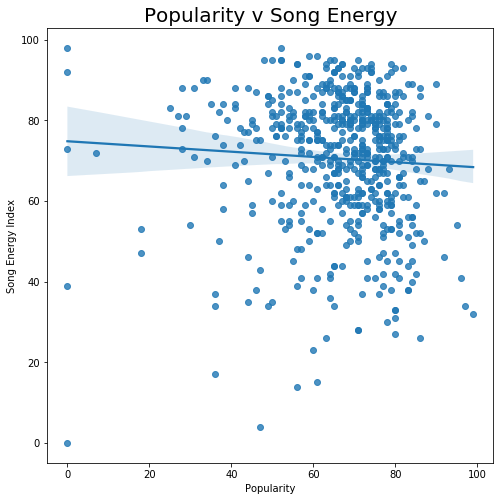

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=dfSounds["pop"], y=dfSounds["nrgy"]).set_title("Popularity v Song Energy", fontsize=20)
ax.set(xlabel="Popularity", ylabel = "Song Energy Index")

[Text(0, 0.5, 'Danceability'), Text(0.5, 0, 'Popularity')]

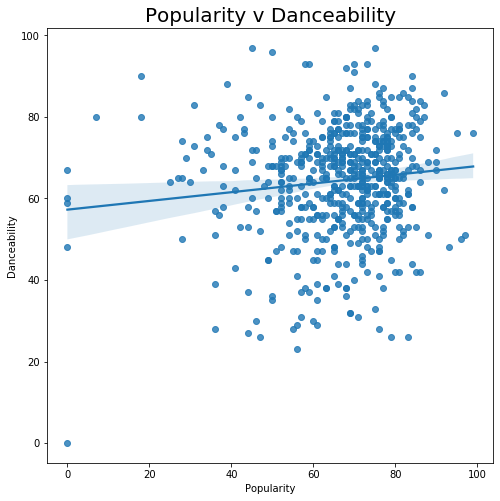

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=dfSounds["pop"], y=dfSounds["dnce"]).set_title("Popularity v Danceability", fontsize=20)
ax.set(xlabel="Popularity", ylabel = "Danceability")

[Text(0, 0.5, 'Beats Per Minute'), Text(0.5, 0, 'Popularity')]

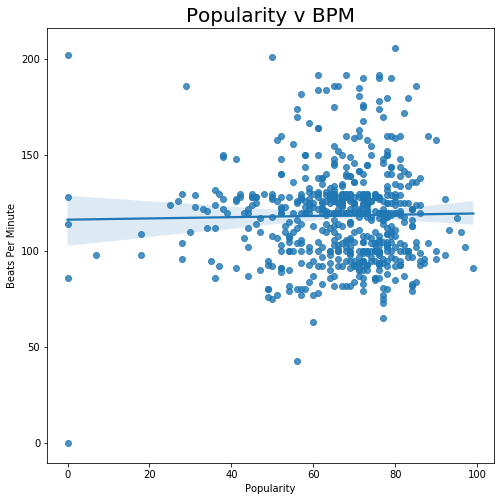

In [16]:
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=dfSounds["pop"], y=dfSounds["bpm"]).set_title("Popularity v BPM", fontsize=20)
ax.set(xlabel="Popularity", ylabel = "Beats Per Minute")

[Text(0, 0.5, 'Length of Song in Seconds'), Text(0.5, 0, 'Popularity')]

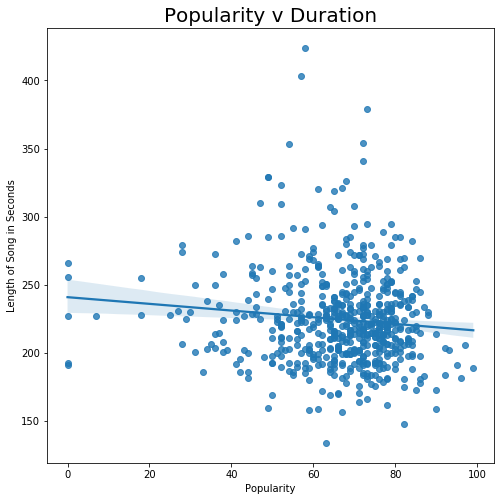

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=dfSounds["pop"], y=dfSounds["dur"]).set_title("Popularity v Duration", fontsize=20)
ax.set(xlabel="Popularity", ylabel = "Length of Song in Seconds")

Above we're seeing some trends that relates some song attributes to their positioning. Let's summarize this below:

In [18]:
#song variables summary
print('Average Energy Index:', round(dfSounds['nrgy'].mean()))
print('Average Danceability Index:', round(dfSounds['dnce'].mean()))
print('Average BPM:', round(dfSounds['bpm'].mean()),'beats per minute')
print('Average Duration:', round(dfSounds['dur'].mean()),'seconds')

Average Energy Index: 71
Average Danceability Index: 64
Average BPM: 119 beats per minute
Average Duration: 225 seconds


While this doesn't come as much of a surprise, we've proven through metrics that most popular songs will be energetic, somewhat danceable, close to 4 minutes long, and will have a steady pace of about 120 beats per minute. Definitely characteristic of majority of pop songs out there today. Even if a song isn't solely classified as pop, it will need these elements in order to have a better chance to make it to headlining streams. While Pop itself may offer a lot more diversity in its sub-genres, big-selling tracks will likely follow the trend above. 

# Conclusion 
***

I have taken a look at song data from the Billboard Hot 100 from the previous 20 years. The most successful selling music genres are Pop, Rock, R&B, Rap, and Country. Majority of songs that peak in the top 10 for each year will be classified as some sort of Pop style by a large margin. Additionally, a vast majority of artists that have a song featured on Billboard will have at least two or more featured songs on the chart as well. What this entails is that the best-selling music, at least by Billboard standards, is concentrated on very few artists and very few styles. This is confirmed by looking at song elements that's associated with popularity. Songs with more Pop-style elements will have a better chance of gaining commercial success. 

After looking at data that looks at music genre taste in the U.S. for 2018, I've shown that some other genres like Rock and R&B have a larger target audience than is indicated by Billboard. Therefore, in order for artists in these less-than-popular genres to become commercially successful, they should either 1) focus on generating revenue through mediums that aren't reported by Billboard such as live events or 2) incorporate more mainstream song elements into their musical style. This is a common theme nowadays with artists like Taylor Swift, who started as a successful country artist but gained prominence by shifting her style  more towards mainstream Pop. 

Going forward, this breakdown wasn't intended to reveal some unforseen revelation. However, it does go to show how data science can help veer an artist towards financial success. Instead of randomly selecting locations to perform, for example, one could analyze music genre tastes by area to target a select population. While some may like to think they have a good grasp on where their fans are, looking at the numbers could open opportunities for playing for a fanbase in an area they would've never thought of playing at. Additionally, knowing what mediums to release your music would help with unnecesscary costs associated with say, streaming if it turns out to be of little utility. 

Overall, instead of looking at Billboard as a hallmark of success, you need to research your target audience to see how you can best reach out to them. If you don't have the audience, it's time to restructure your art.